## SVM with HOG features
Another approach to detect faces is using a Histogram of Oriented Gradients (HOG) in combination with a support vector machine as classifier.
HOG is a feature descriptor and is commonly used in image processing that was published by Dalal and Triggs. The algorithm typically consists of the following steps:
1. Image Preprocessing
2. Calculate Gradient
3. Create Histogram of Oriented Gradients
4. Normalise Histogram Vectors

In the following, we will give a brief overview of the steps in HOG.

### HOG Steps

#### Step 1 - Image Preprocessing

HOG (Histogram of Oriented Gradients) is only used on the part of the image that is relevant for examining a particular subject (a face in our case). For this purpose, it is necessary to first crop this part of the image. For the subsequent calculation of gradients in blocks, the cropped image is resized to a width-to-height ratio of 1:2. In the publication by Dalal and Triggs, 64:128 was chosen because it provided enough information for pedestrian recognition, which was the primary focus of the publication. This image is then divided into blocks of size 8x8, as features are extracted from blocks of pixels rather than individual pixels. Graphically, one can envision this as an 8x16 grid of 8x8 blocks drawn on the image.

#### Step 2 - Calculate Gradient

Since edges represent the boundaries between regions in the image with a significant change in intensity, they are essential to determine the contours of an image. The contours of an image often suffice to classify the objects in the image (a face in our case). To determine the edges, the gradient vector is used because it indicates the direction of the greatest local change in intensity, and its magnitude represents the extent of the change. The gradient vector of a 2-dimensional image is mathematically the partial derivative in the x and y directions. Since the colors of images in computers are represented by discrete color values and are not continuous as in reality, the change in the x and y directions is calculated as follows:
Let $I$ be a function that takes as input the x and y positions of a pixel in the image and outputs the intensity (between 0 and 255). Then, the partial derivative in the x-direction and hence the gradient component $G_x$ is calculated as follows: $G_x = I(x+1, y) - I(x-1, y)$. Similarly, the partial derivative in the y-direction and hence the gradient component $G_y$ is calculated as follows: $G_y = I(x, y+1) - I(x, y-1)$. Thus, the changes in intensity are calculated by considering the horizontal and vertical neighbors of a pixel.
Consider the following image as an example for the pixel with intensity 60, where only 4 out of the 64 values of the 8x8 block are displayed:

![Alt text](images/Hog8x8Grid.png)

For the pixel 60 on the image, the gradient in x-direction will be:
$$G_x = I(x+1, y) - I(x-1, y) = 70 - 40 = 30$$

and for the y-direction:
$$G_y = I(x, y+1) - I(x, y-1) = 70 - 20 = 50$$

Using the gradient in x and y direction, the magnitude and direction of the gradient vector will be calculated using:
$$\text{magnitude} = \sqrt{G_x^2 + G_y^2}$$
$$\text{direction} = \arctan\left(\frac{G_y}{G_x}\right)$$

Here, it should be noted that arctan has a range of values from -90 to 90 degrees, which does not cover a full circle of 360 degrees. In practice, the function arctan2 is often used, which has a range of values from -180 degrees to 180 degrees, thus allowing a bijective mapping to 0-360 degrees. For the example, the calculation looks as follows:
$$\sqrt{G_x^2 + G_y^2} = \sqrt{30^2 + 50^2} \approx 58.31 $$

and the direction would be:
$$\arctan\left(\frac{50}{30}\right) \approx 59.04 \degree $$

This calculation is performed for each pixel in the 8x8 grid, resulting in an 8x8 matrix for the magnitude and an 8x8 matrix for the direction of the gradient vectors. The border is a special case that needs to be addressed (i.e. by using padding). If the image has colors, the calculation is performed for each color channel of a pixel, and the gradient vector with the greatest magnitude is selected from the color channels. The direction of the selected vector is then assigned to the 8x8 direction matrix, and the magnitude of the selected vector is assigned to the 8x8 magnitude matrix for this pixel.

#### Step 3 - Create Histogram of Oriented Gradients

The next step involves creating histograms from the 8x8 matrices of magnitude and direction for all 8x8 blocks obtained in Step 2.

![Alt text](images/HOGDia.png) 

On the x-axis are the various directions of the gradient vectors of the respective pixels within an 8x8 block, and on the y-axis is the sum of the magnitude of the gradient vectors for each direction. Usually, only directions between 0-180 degrees are considered, and anything beyond is reduced to this interval due to the symmetry of the gradient. The symmetry of the gradient implies that a strong change in intensity within the range of 180-360 degrees only differs in sign from a strong change in intensity within the range of 0-180 degrees. This means that angles greater than 180 degrees can be brought into the interval between 0-180 degrees by subtracting 180 degrees beforehand without losing important information. The 180 degrees are divided into 9 different bins (0, 20, 40, 60, 80, 100, 120, 140, 160) on the x-axis, and the calculation of the magnitude for these bins is as follows:

Case 1) Precise Allocation Possible
If precise allocation into a bin is possible (e.g., if a pixel has a magnitude of 50 and a direction of 20 degrees), then 50 is added to the sum of the 20-degree bin.

Case 2) Precise Allocation Not Possible
If precise allocation into a bin is not possible (e.g., if a pixel has a magnitude of 50 and a direction of 30 degrees), then the proximity of the pixel to the classes between which it lies (here 20 and 40) is taken as a weight (here, $\frac{1}{2}$ each, as 30 is exactly between 20 and 40). The weight is multiplied by the magnitude and added to the sum of the respective bin. In this example, $\frac{1}{2} \cdot 50 = 25$ is added to the sum of both the 20-degree and 40-degree bins.

Case 3) Angle Between 160 and 180 Degrees:
In this case, everything operates similarly to Case 2), with the difference that even though the proximity of the pixel between the classes of 160 and 180 is calculated, the result of $\text{weight for 180} \cdot \text{magnitude of the vector}$ is added to the sum of the bin in class 0 due to symmetry. However, the result of $\text{weight for 160} \cdot \text{magnitude of the vector}$ is added to the sum of the bin in class 160, similar to Case 2).

When performing this calculation for each pixel of the 8x8 block, the resulting output is the histogram. This histogram can be transformed into a 9x1 vector containing the weighted sum of magnitudes as entries. For an image with dimensions of 64x128, divided into an 8x16 grid of 8x8 blocks, there would then be $8 \cdot 16 = 128$ such 9x1 vectors.

#### Step 4 - Normalise Histogram Vectors

The gradient of an image is sensitive to the overall illumination of the image. When darkening the image (e.g., by halving the intensity values), the length of the gradient vector also halves, resulting in the values in the histogram being halved as well. However, a face should not have different features with half the intensity, which is why the vector needs to be normalized. For normalization, Dalal and Triggs tested various methods. A typical method frequently used for HOG nowadays constructs a 16x16 block from four 8x8 blocks and combines the information into a 36x1 vector (four 9x1 vectors). This vector with 36 entries ($v_1$ to $v_{36}$) is normalized using the L2-norm:

$$\text{magnitude} = \sqrt{v_1^2 + v_2^2 + ..... + v_{36}^2}$$
$$\text{normalised vector} = [\frac{v_1}{\text{magnitude}}, \frac{v_2}{\text{magnitude}}, ....., \frac{v_{36}}{\text{magnitude}}]$$

To extract information from the entire image with dimensions of 64x128, divided into an 8x16 grid of 8x8 blocks, the 16x16 block is first placed at the top left of the image. Then, the block is moved from left to right with a step size of 1 through the entire row of the image. Once a row is completed, the process continues with the next row, iterating until the block traverses the entire image (similar to a sliding window). The block can be shifted a total of 7 times per row and 15 times downwards, resulting in performing $7 \cdot 15$ computations that yield a 36x1 vector as a result. Thus, a total of $7 \cdot 15 \cdot 36 \cdot 1 = 3780$ different entries are obtained, which are transformed into a 3780x1 vector and then passed on to a classifier (e.g., a Support Vector Machine (SVM)). Before passing it to an SVM, this vector probably has to be reduced (to prevent overfitting) using for instance PCA (Principal Component Analysis). However, this will not be explained in this article.

### SVM with HOG features

The resulting vector from the HOG algorithm, that was potentially reduced using PCA, is often fed to an SVM. The SVM tries to find a hyperplane that best separates the datapoints of different classes in a high-dimensional space. On a basic level, the datapoints can be classified into images that contain a face (positive samples), and images that don't contain a face (negative samples). The HOG features extracted from negative and positive samples can then be used to train the SVM so that it learns to distinguish between images that contain faces and ones that don't. Additionally, a trained SVM can be used as a sliding window that analyses a small part of a predefined size of the image to determine whether this part contains a face or not. This allows to not only classify images with faces correctly, but also to detect faces on the image.


## Practical Application

In order to test an SVM with HOG features in practice, we decide to use the LFW dataset that is built-in sklearn. To start, we imported the dataset:


In [115]:
from typing import Callable

import cv2
import numpy as np
import dlib
from PIL import Image, ImageFilter
from sklearn import datasets
from matplotlib import pyplot as plt
import sys
sys.path.append('../test/')
import ImageModification as imod

def get_faces():
    return datasets.fetch_lfw_people(color=True, min_faces_per_person=100, resize=1)

Afterwards, we created the function `count_detected_faces_hog` that counts the number of faces that the SVM classifier with HOG features from dlib detected. The parameter `image_mod_fn` is a function that modifies the image before it is fed to the SVM classifier.

In [116]:
def count_detected_faces_hog(image_mod_fn: Callable[[np.ndarray], np.ndarray]):
    faces = get_faces()
    detector = dlib.get_frontal_face_detector()
    counter_faces = 0

    for possibleFace in faces.images:
        scaled_rgb_image = (possibleFace * 255).astype(np.uint8)

        modifiedImage = image_mod_fn(scaled_rgb_image)

        detected_faces = detector(modifiedImage)

        if len(detected_faces) > 0:
            counter_faces += 1

    return float(counter_faces) / float(len(faces.images))

Then we used several modifications and plotted the success rate of detecting the faces in 1288 images:

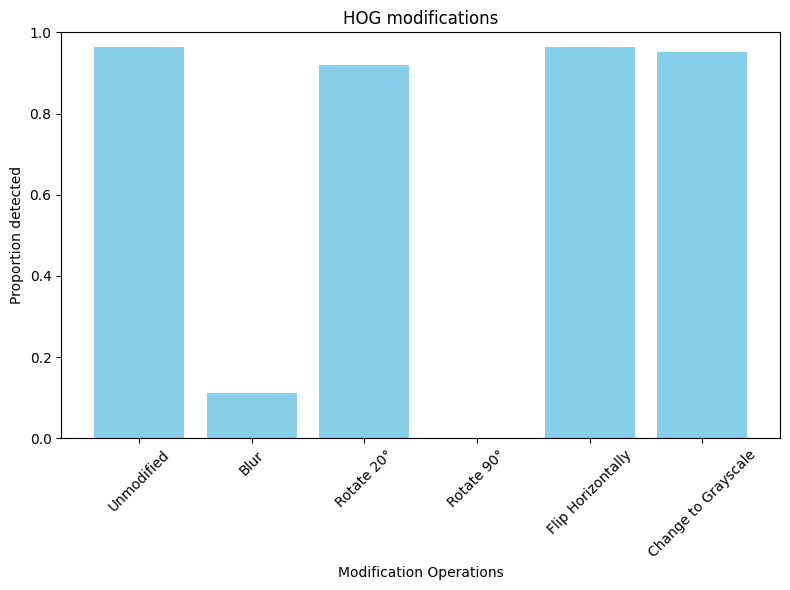

In [117]:
def image_modification_plot(count_detected_faces: Callable[[Callable[[np.ndarray], np.ndarray]], float], title: str):
    categories = ["Unmodified", "Blur", "Rotate 20°", "Rotate 90°", "Flip Horizontally", "Change to Grayscale"]
    values = [count_detected_faces(imod.identity), count_detected_faces(imod.apply_blur),
              count_detected_faces(imod.create_rotate_image(20)),
              count_detected_faces(imod.create_rotate_image(90)), count_detected_faces(imod.flip_image_horizontally),
              count_detected_faces(imod.change_to_grayscale)]

    # Create bar chart
    plt.figure(figsize=(8, 6))
    plt.bar(categories, values, color='skyblue')
    plt.ylim(0, 1.0)

    # Title and labels
    plt.title(title)
    plt.xlabel('Modification Operations')
    plt.ylabel('Proportion detected')

    # Show plot
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    plt.tight_layout()
    plt.show()
    
image_modification_plot(count_detected_faces_hog, "HOG modifications")

The bar chart shows that HOG is not susceptible to a horizontal flip, a conversion to grayscale, and a small rotation, but it is susceptible to blur and a 90° rotation.

TODO: Schlauere Varianten probieren, die Menschen nicht erkennen